# Pitch slant analysis for H and V pol

Just looking at the variation in returned properties for full size, no legs, 

In [9]:
import sys
sys.path.append('/Users/sstk4353/packages/.')

from WIPL_python_analysis.SinglePolPlots import SinglePolPlots
from WIPL_python_analysis.DualPol import DualPol
from WIPL_python_analysis.DictToSinglePolResults import OutputDictToSinglePolResultsConverter as converter
import WIPL_python_analysis.helper_functions as hf
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('./')

In [4]:
def plot_corrected_rcs(df, title=None):
    phi = df['phi']
    corrected_rcs = df['Corrected_RCS']
    
    plt.figure(figsize=(8, 6))
    plt.plot(phi, corrected_rcs, label='Corrected RCS')
    plt.xlabel('Azimuth (degrees)')
    plt.ylabel('Corrected RCS (cm^2)')

    if title:
        plt.title(title)

    plt.legend()
    plt.show()

In [5]:
BASE_DRIVE_PATH = '/Users/sstk4353/Library/CloudStorage/GoogleDrive-thomas.matthews@ncas.ac.uk/My Drive/WIPL/Bernard_ellipsoid_comparison/'
BERNARD_PATH = 'Bernard/'
ELLIPSOID_PATH = 'Ellipsoid/'

In [23]:
pol_list = ['H', 'V']
pitch_list = list(range(0,11))
slant = 0
slant_name = '0'



In [35]:
pitch_result_dict = {x : {y : None for y in pitch_list} for x in pol_list}
pitch_result_dict_ellipsoid = {x : {y : None for y in pitch_list} for x in pol_list}

In [16]:
def de_alias(aliased_data):

    number_of_points = len(aliased_data)
    de_aliased_data = np.zeros(number_of_points)

    de_aliased_data[0] = aliased_data[0]

    for counter in range(1, number_of_points):

        difference = aliased_data[counter] - de_aliased_data[counter-1]
        if np.abs(difference) > 180:
            if difference > 0:
                de_aliased_data[counter] = aliased_data[counter] - 360
            elif difference < 0:
                de_aliased_data[counter] = aliased_data[counter] + 360
        else:
            de_aliased_data[counter] = aliased_data[counter]

    return de_aliased_data

In [39]:
for pol in pol_list:
    for pitch in pitch_list:
        path = BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/dict/body_pitch_sweep/Bernard_parameterised_560_{pol}_M_{1000}_body_p{pitch}_s0_dict.pkl'
        conv = converter.from_pickle(path)
        df = conv.generate_output_df()
        
        output_path = BASE_DRIVE_PATH + BERNARD_PATH + f'parameterised/csv/body_pitch_sweep/Bernard_parameterised_560_{pol}_M_{1000}_body_p{pitch}_s0_df.csv'
        df.to_csv(output_path)
        pitch_result_dict[pol][pitch] = df

In [40]:
for pol in pol_list:
    for pitch in pitch_list:
        path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/dict/pitch_slant_analysis/Ellipsoid_parameterised_560_{pol}_{1000}_p{pitch}_s0_dict.pkl'
        conv = converter.from_pickle(path)
        df = conv.generate_output_df()
        
        output_path = BASE_DRIVE_PATH + ELLIPSOID_PATH + f'parameterised/csv/pitch_slant_analysis/Ellipsoid_parameterised_560_{pol}_{1000}_p{pitch}_s0_df.csv'
        df.to_csv(output_path)
        pitch_result_dict_ellipsoid[pol][pitch] = df

In [12]:
pol_list = ['H', 'V']
vars_list = ['HH_power', 'VV_power', 'Zdr', 'LDR', 'HH_phase', 'VV_phase', 'PhiDP', 'PhiDP_de_aliased']

In [13]:
units_dict = {
    'HH_power': 'proportional',
    'VV_power': 'proportional',
    'Zdr': 'dB',
    'LDR': 'dB',
    'HH_phase': 'degrees',
    'VV_phase': 'degrees',
    'HH_phase_de_aliased': 'degrees',
    'VV_phase_de_aliased': 'degrees',
    'PhiDP': 'degrees',
    'PhiDP_de_aliased': 'degrees',
    'PhiDP_pre_de_aliased': 'degrees'
}

In [41]:
body_results_dict = {y : {z : None for z in vars_list} for y in range(20)}


for pitch in pitch_list: 
    body_results_dict[pitch]['HH_power'] = hf.get_horizontal_returned_power(pitch_result_dict['H'][pitch])
    body_results_dict[pitch]['VV_power'] = hf.get_vertical_returned_power(pitch_result_dict['V'][pitch])
    body_results_dict[pitch]['HH_phase'] = hf.get_horizontal_returned_phase(pitch_result_dict['H'][pitch])
    body_results_dict[pitch]['VV_phase'] = hf.get_vertical_returned_phase(pitch_result_dict['V'][pitch])
    # body_results_dict[coordinate_row]['HH_phase_de_aliased'] = de_alias(body_results_dict[coordinate_row]['HH_phase'])
    # body_results_dict[coordinate_row]['VV_phase_de_aliased'] = de_alias(body_results_dict[coordinate_row]['VV_phase'])
    body_results_dict[pitch]['LDR'] = hf.get_linear_depol_ratio(pitch_result_dict['H'][pitch])

    dp = DualPol(pitch_result_dict['H'][pitch], pitch_result_dict['V'][pitch], read_from_df=True)
    dp._calculate_differential_reflectivity()
    dp._calculate_differential_phase()

    body_results_dict[pitch]['Zdr'] = dp.differential_reflectivity
    body_results_dict[pitch]['PhiDP'] = dp.differential_phase
    body_results_dict[pitch]['PhiDP_de_aliased'] = de_alias(dp.differential_phase)
    # ellipsoid_results_dict[coordinate_row]['PhiDP_de_aliased'] = de_alias(ellipsoid_results_dict[coordinate_row]['PhiDP'])
    # ellipsoid_results_dict[coordinate_row]['PhiDP_pre_de_aliased'] = np.rad2deg(phi_dp(np.angle(dp.resultant_phi_field), np.angle(dp.resultant_theta_field)))

In [42]:
ellipsoid_results_dict = {y : {z : None for z in vars_list} for y in range(20)}


for pitch in pitch_list: 
    ellipsoid_results_dict[pitch]['HH_power'] = hf.get_horizontal_returned_power(pitch_result_dict_ellipsoid['H'][pitch])
    ellipsoid_results_dict[pitch]['VV_power'] = hf.get_vertical_returned_power(pitch_result_dict_ellipsoid['V'][pitch])
    ellipsoid_results_dict[pitch]['HH_phase'] = hf.get_horizontal_returned_phase(pitch_result_dict_ellipsoid['H'][pitch])
    ellipsoid_results_dict[pitch]['VV_phase'] = hf.get_vertical_returned_phase(pitch_result_dict_ellipsoid['V'][pitch])
    # body_results_dict[coordinate_row]['HH_phase_de_aliased'] = de_alias(body_results_dict[coordinate_row]['HH_phase'])
    # body_results_dict[coordinate_row]['VV_phase_de_aliased'] = de_alias(body_results_dict[coordinate_row]['VV_phase'])
    ellipsoid_results_dict[pitch]['LDR'] = hf.get_linear_depol_ratio(pitch_result_dict_ellipsoid['H'][pitch])

    dp = DualPol(pitch_result_dict_ellipsoid['H'][pitch], pitch_result_dict_ellipsoid['V'][pitch], read_from_df=True)
    dp._calculate_differential_reflectivity()
    dp._calculate_differential_phase()

    ellipsoid_results_dict[pitch]['Zdr'] = dp.differential_reflectivity
    ellipsoid_results_dict[pitch]['PhiDP'] = dp.differential_phase
    ellipsoid_results_dict[pitch]['PhiDP_de_aliased'] = de_alias(dp.differential_phase)
    # ellipsoid_results_dict[coordinate_row]['PhiDP_de_aliased'] = de_alias(ellipsoid_results_dict[coordinate_row]['PhiDP'])
    # ellipsoid_results_dict[coordinate_row]['PhiDP_pre_de_aliased'] = np.rad2deg(phi_dp(np.angle(dp.resultant_phi_field), np.angle(dp.resultant_theta_field)))

In [28]:
def plot_results_by_pitch(results_dict, var, title_centre, pitch_list, linestyle, alpha):
    for pitch in pitch_list: 
        plt.plot(df['phi'], results_dict[pitch][var], label=f'{pitch}', linestyle = linestyle, alpha=alpha)


    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.legend()
    plt.xlabel('Phi (degrees)')
    plt.ylabel(f'{var} ({units_dict[var]})')
    plt.title(f'Variation of {var} for {title_centre} at 5.6GHz')
    plt.show()

# Plot Bernard body

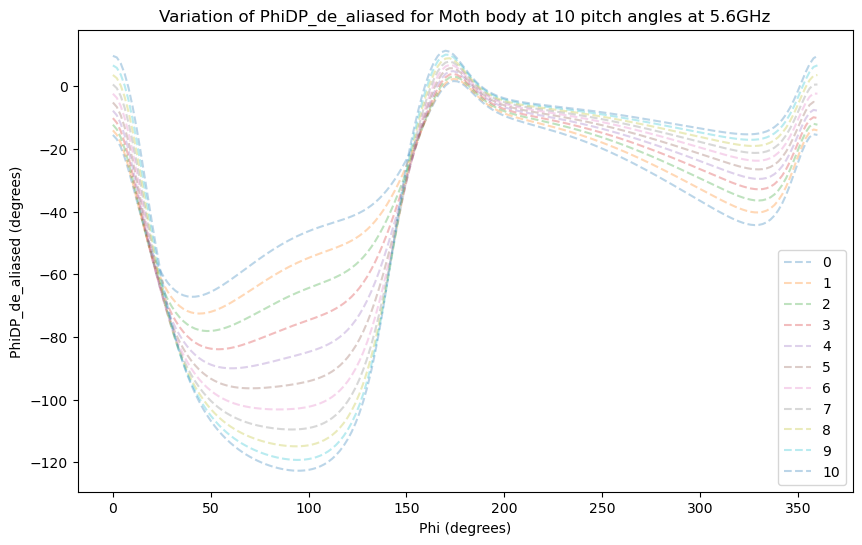

In [45]:
title_centre = "Moth body at 10 pitch angles"

linestyle = '--'
alpha = 0.3
num_configs = 20 
results_dictionary =body_results_dict


# plot_results_by_pitch(body_results_dict, 'HH_power', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(body_results_dict, 'VV_power', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(body_results_dict, 'HH_phase', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(body_results_dict, 'VV_phase', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(body_results_dict, 'Zdr', title_centre, pitch_list, linestyle, alpha)
plot_results_by_pitch(body_results_dict, 'PhiDP_de_aliased', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(body_results_dict, 'LDR', title_centre, pitch_list, linestyle, alpha)

# Plot Ellipsoid

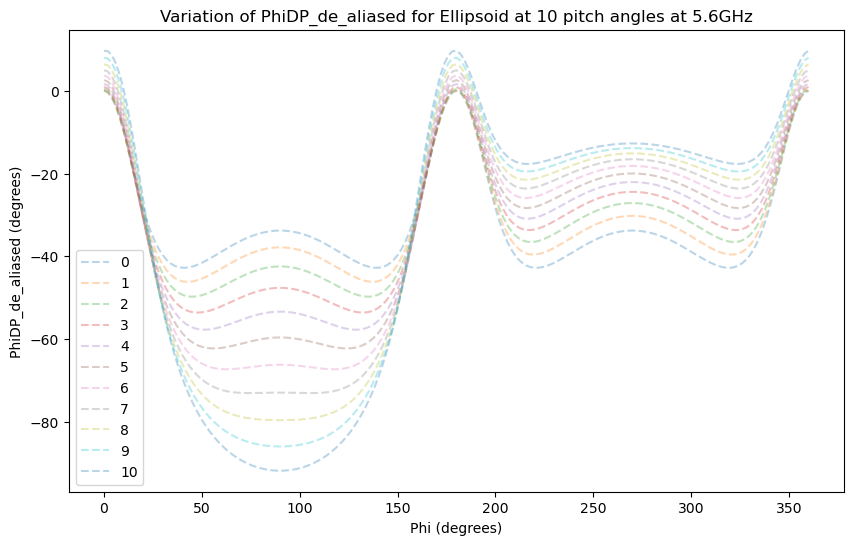

In [46]:
title_centre = "Ellipsoid at 10 pitch angles"

linestyle = '--'
alpha = 0.3
num_configs = 20 
results_dictionary =ellipsoid_results_dict


# plot_results_by_pitch(results_dictionary, 'HH_power', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(results_dictionary, 'VV_power', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(results_dictionary, 'HH_phase', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(results_dictionary, 'VV_phase', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(results_dictionary, 'Zdr', title_centre, pitch_list, linestyle, alpha)
plot_results_by_pitch(results_dictionary, 'PhiDP_de_aliased', title_centre, pitch_list, linestyle, alpha)
# plot_results_by_pitch(results_dictionary, 'LDR', title_centre, pitch_list, linestyle, alpha)